Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Data (Encoder)

In [2]:
# Data: (distance_m, encoder_count)
data = [
    (1.015, -3606),
    (1.04,  -3698),
    (1.03,  -3479),
    (1.11,  -3794),
    (1.05,  -3707),
    (1.12,  -3947),
    (1.15,  -3910),
    (1.11,  -3822),
    (1.12,  -3913),
    (1.16,  -3960),
    (1.11,  -3838),
    (1.13,  -3907),
    (1.095, -3772),
    (1.15,  -3991),
]

s = np.array([d for (d, _) in data], dtype=float)      # distance (m)
e = np.array([c for (_, c) in data], dtype=float)      # encoder counts (can be negative)

e_fwd = -e  # forward counts (positive)

# Sanity check:
print("min/max e_fwd:", e_fwd.min(), e_fwd.max())

min/max e_fwd: 3479.0 3991.0


Fit a line through origin

In [3]:
k = (e_fwd @ s) / (e_fwd @ e_fwd)
print("k (meters per count) =", k)

def f_se(e_counts):
    """Map forward encoder counts -> predicted distance (m)."""
    return k * e_counts

k (meters per count) = 0.00028851708972299


Plot 1:

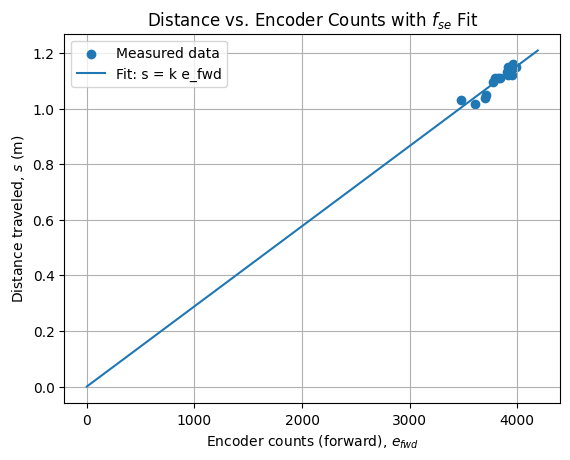

In [4]:
s_hat = f_se(e_fwd)

plt.figure()
plt.scatter(e_fwd, s, label="Measured data")
# Plot the fit on a dense x-grid
xgrid = np.linspace(0, e_fwd.max()*1.05, 200)
plt.plot(xgrid, f_se(xgrid), label="Fit: s = k e_fwd")

plt.xlabel("Encoder counts (forward), $e_{fwd}$")
plt.ylabel("Distance traveled, $s$ (m)")
plt.title("Distance vs. Encoder Counts with $f_{se}$ Fit")
plt.grid(True)
plt.legend()
plt.show()

Variance (Encoder)

In [5]:
residual = s - s_hat
sq_err = residual**2

print("Residual stats (m):")
print("  mean =", residual.mean())
print("  std  =", residual.std())
print("Squared error stats (m^2):")
print("  min  =", sq_err.min())
print("  max  =", sq_err.max())

Residual stats (m):
  mean = -4.683101308424119e-05
  std  = 0.016923988943809337
Squared error stats (m^2):
  min  = 2.1659158556055992e-06
  max  = 0.0007255587516846058


Model fit for variance

In [34]:
# e_fwd >= 0
# sq_err = (s - s_hat)^2

# Linear fit through origin: sq_err ≈ k_ss * e_fwd
k_ss = (e_fwd @ sq_err) / (e_fwd @ e_fwd)

# enforce non-negativity (variance must be >= 0)
k_ss = max(0.0, k_ss)

print("k_ss =", k_ss, " (m^2 per count)")

def f_ss(e_counts):
    """Map forward encoder counts -> predicted variance sigma_s^2 (m^2)."""
    e = np.asarray(e_counts, dtype=float)
    return k_ss * e


k_ss = 7.342396346880917e-08  (m^2 per count)


Plot 2

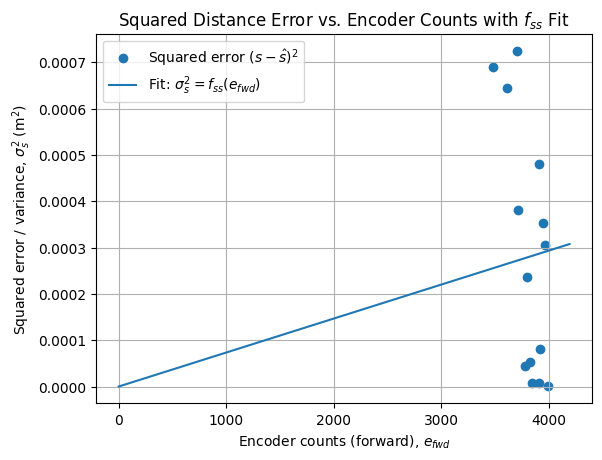

In [35]:
sig2_hat = f_ss(e_fwd)

plt.figure()
plt.scatter(e_fwd, sq_err, label="Squared error $(s-\\hat{s})^2$")
plt.plot(xgrid, f_ss(xgrid), label="Fit: $\\sigma_s^2 = f_{ss}(e_{fwd})$")

plt.xlabel("Encoder counts (forward), $e_{fwd}$")
plt.ylabel("Squared error / variance, $\\sigma_s^2$ (m$^2$)")
plt.title("Squared Distance Error vs. Encoder Counts with $f_{ss}$ Fit")
plt.grid(True)
plt.legend()
plt.show()


In [36]:
def f_se_raw(e_raw):
    """Raw encoder count -> distance (m). Forward raw counts are negative."""
    return f_se(-np.asarray(e_raw, dtype=float))

def f_ss_raw(e_raw):
    """Raw encoder count -> variance (m^2). Forward raw counts are negative."""
    return f_ss(-np.asarray(e_raw, dtype=float))

Encoder Counts to Distance Mapping

We construct a function that maps encoder count changes to the distance traveled by the robot. Let $s$ denote the traveled distance (m) and let $e$ denote the integer encoder count change. Because our encoder counts are negative when driving forward, we define a forward-count variable $e_{\mathrm{fwd}}=-e$ so that forward motion corresponds to positive values. Our goal is to fit a function
\begin{equation}
s = f_{se}(e_{\mathrm{fwd}}).
\end{equation}
We collect a dataset of paired measurements $\{(e_{\mathrm{fwd},i}, s_i)\}$ by repeatedly driving the robot forward with zero steering command from the same taped start pose. For each trial, we record the encoder counts from the GUI/logs and measure the final displacement in the ground frame. Assuming near-straight motion, we use $s_i=\sqrt{x_{G,i}^2+y_{G,i}^2}$. We fit a linear model constrained to pass through the origin,
\begin{equation}
f_{se}(e_{\mathrm{fwd}})=k\,e_{\mathrm{fwd}}, \qquad f_{se}(0)=0,
\end{equation}
where the zero-intercept constraint is physically motivated: if the wheels do not rotate (zero counts), the robot should not travel. Using least squares with the origin constraint, the slope is
\begin{equation}
k = \frac{\sum_i e_{\mathrm{fwd},i}\, s_i}{\sum_i e_{\mathrm{fwd},i}^2}.
\end{equation}
We visualize both the measured data $(e_{\mathrm{fwd}}, s)$ and the fitted predictions $\hat{s}=f_{se}(e_{\mathrm{fwd}})$ on a single plot.

\subsection{Distance Uncertainty as a Function of Encoder Counts}

Next, we estimate the distance uncertainty induced by encoder-based odometry. For each trial, we compute the residual between measured and predicted distance,
\begin{equation}
\varepsilon_i = s_i - \hat{s}_i,
\end{equation}
and treat the squared residual $\varepsilon_i^2$ as an empirical estimate of the distance variance $\sigma_s^2$ for that encoder count. We then fit a second function
\begin{equation}
\sigma_s^2 = f_{ss}(e_{\mathrm{fwd}}),
\end{equation}
which we allow to be non-linear. In our implementation, we use a quadratic model constrained through the origin,
\begin{equation}
f_{ss}(e_{\mathrm{fwd}})=a_1 e_{\mathrm{fwd}} + a_2 e_{\mathrm{fwd}}^2,
\end{equation}
and estimate $(a_1,a_2)$ by least squares on the dataset $\{(e_{\mathrm{fwd},i}, \varepsilon_i^2)\}$. We plot the squared residuals $\varepsilon^2$ versus $e_{\mathrm{fwd}}$ and overlay the predicted variance curve $f_{ss}(e_{\mathrm{fwd}})$ on the same figure. When using this model downstream, we clamp negative variance predictions to zero to preserve physical validity.


Yawrate data

In [11]:
data = [
    # alpha=+10, v=100 (6 trials)
    ( 10, 100, 95,   56,   3.5),
    ( 10, 100, 96,   60,   3.5),
    ( 10, 100, 95,   60,   3.5),
    ( 10, 100, 96,   60,   3.5),
    ( 10, 100, 97,   63,   3.5),
    ( 10, 100, 100,  57,   3.5),

    # alpha=+10, v=80 (5 trials)
    ( 10, 80,  81,   39.5, 3.5),
    ( 10, 80,  86,   42,   3.5),
    ( 10, 80,  83,   43,   3.5),
    ( 10, 80,  86,   45,   3.5),
    ( 10, 80,  80,   43,   3.5),

    # alpha=+15, v=100 (5 trials)
    ( 15, 100, 80,   82,   3.5),
    ( 15, 100, 80.5, 81,   3.5),
    ( 15, 100, 78,   85.5, 3.5),
    ( 15, 100, 75,   87.5, 3.5),
    ( 15, 100, 76,   80,   3.5),

    # alpha=-10, v=100 (5 trials)
    (-10, 100, 104,  70,   3.5),
    (-10, 100, 102,  67,   3.5),
    (-10, 100, 100,  74,   3.5),
    (-10, 100, 101,  70,   3.5),
    (-10, 100, 102.5,72,   3.5),

    # alpha=-10, v=80 (5 trials)
    (-10, 80,  77,   47,   3.5),
    (-10, 80,  82,   55,   3.5),
    (-10, 80,  81,   52,   3.5),
    (-10, 80,  80.5, 51.5, 3.5),
    (-10, 80,  79.5, 57.5, 3.5),

    # alpha=-15, v=100 (5 trials)
    (-15, 100, 69.5, 91,   3.5),
    (-15, 100, 70.5, 91.5, 3.5),
    (-15, 100, 69,   91,   3.5),
    (-15, 100, 68,   93.5, 3.5),
    (-15, 100, 69,   93,   3.5),
]

arr = np.array(data, dtype=float)
alpha_deg = arr[:,0]
v_cmd     = arr[:,1]
x_plus    = arr[:,2]
y_plus    = arr[:,3]
t         = arr[:,4]

In [12]:
# undo offsets (cm)
x_cm = x_plus - 24.5
y_cm_mag = y_plus - 10.0

# sign convention: +y means "to the right" when alpha > 0
y_cm = np.sign(alpha_deg) * y_cm_mag

# convert to meters
x_m = x_cm / 100.0
y_m = y_cm / 100.0

Encoder counts per second vs set speed

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data: delta encoder counts (negative for forward), duration per speed
data = {
    100: {"T": 3.5, "de": [-3606, -3698, -3479, -3794, -3707, -3947, -3910, -3822, -3913, -3960, -3838, -3907, -3772, -3991]},
    60:  {"T": 3.0, "de": [-1440, -1497, -1361, -1485, -1555]},
    80:  {"T": 3.0, "de": [-2759, -2669, -2750, -2734, -2748]},
}

# Build trial-level arrays
v_list = []
r_list = []  # counts/s (forward)
for v, d in data.items():
    T = d["T"]
    for de in d["de"]:
        e_fwd = -float(de)          # make forward positive
        r = e_fwd / T               # counts per second
        v_list.append(float(v))
        r_list.append(r)

v_arr = np.array(v_list)
r_arr = np.array(r_list)

print("Total trials:", len(r_arr))
print("Example rates (first 5):", r_arr[:5])


Total trials: 24
Example rates (first 5): [1030.28571429 1056.57142857  994.         1084.         1059.14285714]


In [6]:
def fit_poly_through_origin(v, r, degree):
    # Design matrix: [v, v^2, ..., v^degree]
    X = np.vstack([v**p for p in range(1, degree+1)]).T
    coef, *_ = np.linalg.lstsq(X, r, rcond=None)
    r_hat = X @ coef
    rmse = np.sqrt(np.mean((r - r_hat)**2))
    return coef, rmse

fits = {}
for deg in [1, 2, 3]:
    coef, rmse = fit_poly_through_origin(v_arr, r_arr, deg)
    fits[deg] = (coef, rmse)
    print(f"degree {deg} coef = {coef}, RMSE = {rmse}")

best_deg = min(fits.keys(), key=lambda d: fits[d][1])
best_coef = fits[best_deg][0]
print("\nBest degree =", best_deg, "with coef =", best_coef)

def f_r(v):
    v = np.asarray(v, dtype=float)
    out = np.zeros_like(v)
    for i, c in enumerate(best_coef):
        out += c * (v ** (i+1))
    return out


degree 1 coef = [10.71126817], RMSE = 82.25472658607099
degree 2 coef = [6.59847881 0.04429875], RMSE = 64.50078333268995
degree 3 coef = [-2.38974830e+01  8.13690476e-01 -4.65850340e-03], RMSE = 32.82005851954943

Best degree = 3 with coef = [-2.38974830e+01  8.13690476e-01 -4.65850340e-03]


In [7]:
speeds = sorted(data.keys())
v_pts = np.array(speeds, dtype=float)

mean_r = {}
var_r = {}
for v in speeds:
    T = float(data[v]["T"])
    e_fwd = -np.array(data[v]["de"], dtype=float)
    r = e_fwd / T
    mean_r[v] = float(np.mean(r))
    var_r[v] = float(np.var(r, ddof=1)) if len(r) > 1 else 0.0  # sample variance

var_pts = np.array([var_r[v] for v in speeds], dtype=float)

# through-origin linear fit: var ≈ k_sr * v
k_sr = (v_pts @ var_pts) / (v_pts @ v_pts)
k_sr = max(0.0, k_sr)
print("k_sr =", k_sr, "((counts/s)^2 per speed_unit)")

def f_sr(v):
    v = np.asarray(v, dtype=float)
    return k_sr * v

k_sr = 11.153914021579324 ((counts/s)^2 per speed_unit)


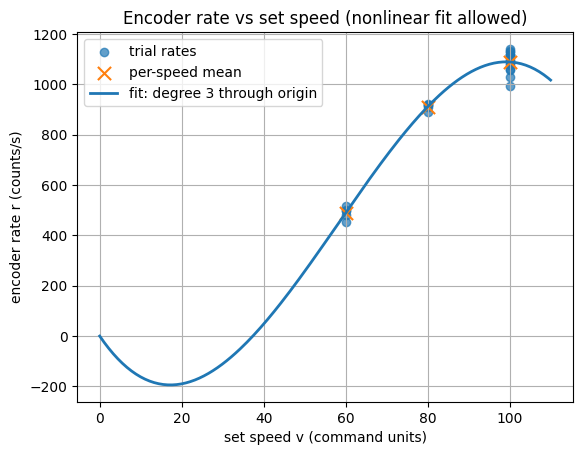

In [8]:
plt.figure()
plt.scatter(v_arr, r_arr, alpha=0.7, label="trial rates")
plt.scatter(v_pts, [mean_r[v] for v in speeds], s=90, marker="x", label="per-speed mean")

vgrid = np.linspace(0, max(speeds)*1.1, 200)
plt.plot(vgrid, f_r(vgrid), linewidth=2, label=f"fit: degree {best_deg} through origin")

plt.xlabel("set speed v (command units)")
plt.ylabel("encoder rate r (counts/s)")
plt.title("Encoder rate vs set speed (nonlinear fit allowed)")
plt.grid(True)
plt.legend()
plt.show()

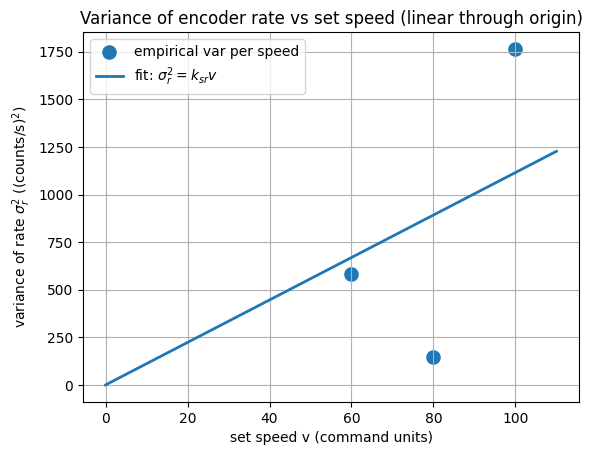

In [9]:
plt.figure()
plt.scatter(v_pts, var_pts, s=90, label="empirical var per speed")

vgrid = np.linspace(0, max(speeds)*1.1, 200)
plt.plot(vgrid, f_sr(vgrid), linewidth=2, label=r"fit: $\sigma_r^2 = k_{sr} v$")

plt.xlabel("set speed v (command units)")
plt.ylabel(r"variance of rate $\sigma_r^2$ ((counts/s)$^2$)")
plt.title("Variance of encoder rate vs set speed (linear through origin)")
plt.grid(True)
plt.legend()
plt.show()


Yaw rate approximation assuming constant curvature

In [13]:
theta = 2.0 * np.arctan2(y_m, x_m)   # radians
w = theta / t                        # rad/s

Plot

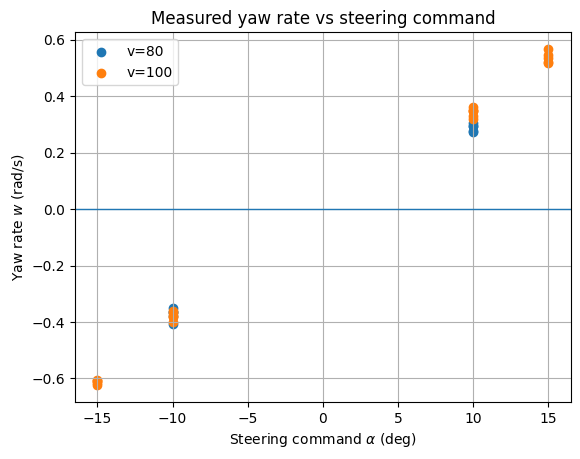

In [14]:
plt.figure()
for vv in sorted(set(v_cmd)):
    m = (v_cmd == vv)
    plt.scatter(alpha_deg[m], w[m], label=f"v={int(vv)}")
plt.axhline(0, linewidth=1)
plt.xlabel("Steering command $\\alpha$ (deg)")
plt.ylabel("Yaw rate $w$ (rad/s)")
plt.title("Measured yaw rate vs steering command")
plt.grid(True)
plt.legend()
plt.show()

Model Fitting

In [16]:
alpha_rad = np.deg2rad(alpha_deg)

# Design variable z = v * alpha (radians)
z = v_cmd * alpha_rad

# Least squares fit with zero intercept: w = k*z
k = (z @ w) / (z @ z)
print("k =", k, "(rad/s) per (speed_unit * rad)")

def f_w(alpha_deg_in, v_cmd_in):
    alpha_rad_in = np.deg2rad(np.asarray(alpha_deg_in, dtype=float))
    v_cmd_in = np.asarray(v_cmd_in, dtype=float)
    return k * v_cmd_in * alpha_rad_in

k = 0.021867824848934528 (rad/s) per (speed_unit * rad)


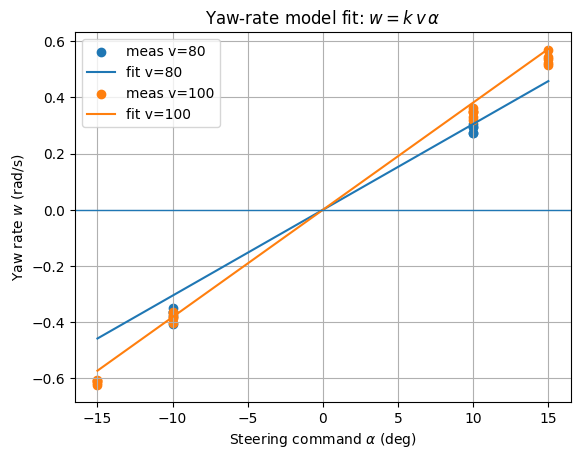

In [17]:
w_hat = f_w(alpha_deg, v_cmd)

plt.figure()
for vv in sorted(set(v_cmd)):
    m = (v_cmd == vv)
    plt.scatter(alpha_deg[m], w[m], label=f"meas v={int(vv)}")
    # predicted curve for that speed
    agrid = np.linspace(alpha_deg.min(), alpha_deg.max(), 200)
    plt.plot(agrid, f_w(agrid, vv*np.ones_like(agrid)), label=f"fit v={int(vv)}")

plt.axhline(0, linewidth=1)
plt.xlabel("Steering command $\\alpha$ (deg)")
plt.ylabel("Yaw rate $w$ (rad/s)")
plt.title("Yaw-rate model fit: $w = k\\,v\\,\\alpha$")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
res = w - w_hat
sigma_w2_const = np.mean(res**2)
sigma_w_const = np.sqrt(sigma_w2_const)

print("Constant variance estimate sigma_w^2 =", sigma_w2_const, "(rad/s)^2")
print("Constant std estimate sigma_w =", sigma_w_const, "rad/s")

def f_sw_const(alpha_deg_in=None, v_cmd_in=None):
    return sigma_w2_const

Constant variance estimate sigma_w^2 = 0.001749354557820946 (rad/s)^2
Constant std estimate sigma_w = 0.04182528610566754 rad/s


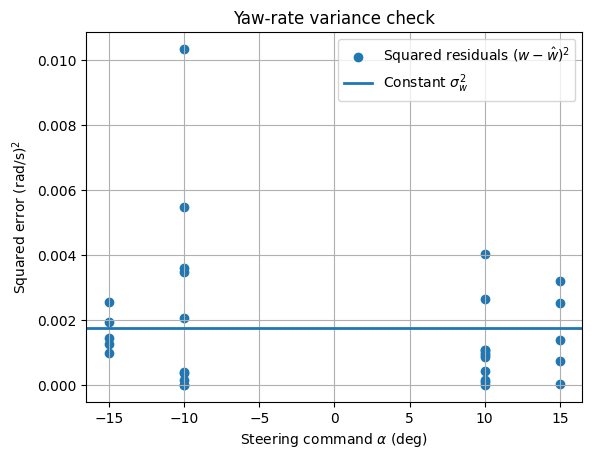

In [19]:
plt.figure()
plt.scatter(alpha_deg, res**2, label="Squared residuals $(w-\\hat{w})^2$")
plt.axhline(sigma_w2_const, label="Constant $\\sigma_w^2$", linewidth=2)

plt.xlabel("Steering command $\\alpha$ (deg)")
plt.ylabel("Squared error (rad/s)$^2$")
plt.title("Yaw-rate variance check")
plt.grid(True)
plt.legend()
plt.show()

In [21]:
# Inputs
ar = np.deg2rad(alpha_deg)   # use radians for alpha

# Build a flexible feature matrix (no symmetry constraint)
# Columns: [1, v, a, v*a, a^2, v^2, v*a^2]
X = np.vstack([
    np.ones_like(v_cmd),
    v_cmd,
    ar,
    v_cmd * ar,
    ar**2,
    v_cmd**2,
    v_cmd * (ar**2),
]).T

beta, *_ = np.linalg.lstsq(X, w, rcond=None)
b0, b1, b2, b3, b4, b5, b6 = beta
print("beta =", beta)

def f_w_flex(v, alpha_deg_in):
    v = np.asarray(v, dtype=float)
    a = np.deg2rad(np.asarray(alpha_deg_in, dtype=float))
    return (b0
            + b1*v
            + b2*a
            + b3*(v*a)
            + b4*(a**2)
            + b5*(v**2)
            + b6*(v*(a**2)))

beta = [-3.85727994e-05 -1.71425418e-03  8.68750169e-01  1.28599305e-02
 -4.80891612e-05  1.66431676e-05 -4.74363582e-03]


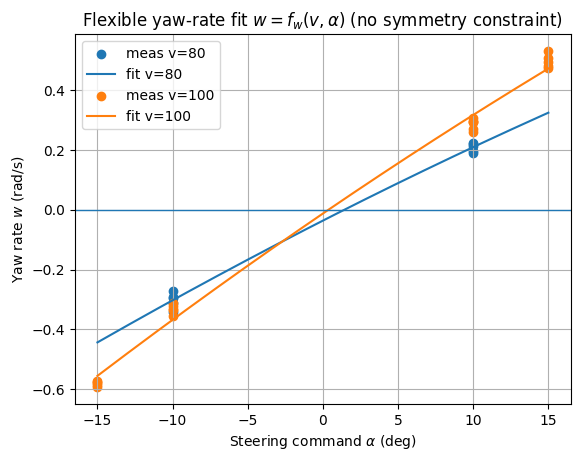

In [21]:
w_hat = f_w_flex(v_cmd, alpha_deg)
res = w - w_hat

plt.figure()
for vv in sorted(set(v_cmd)):
    m = (v_cmd == vv)
    plt.scatter(alpha_deg[m], w[m], label=f"meas v={int(vv)}")

    agrid = np.linspace(alpha_deg.min(), alpha_deg.max(), 200)
    plt.plot(agrid, f_w_flex(vv*np.ones_like(agrid), agrid), label=f"fit v={int(vv)}")

plt.axhline(0, linewidth=1)
plt.xlabel("Steering command $\\alpha$ (deg)")
plt.ylabel("Yaw rate $w$ (rad/s)")
plt.title("Flexible yaw-rate fit $w=f_w(v,\\alpha)$ (no symmetry constraint)")
plt.grid(True)
plt.legend()
plt.show()

sigma_w^2 = 0.001749354557820946 (rad/s)^2


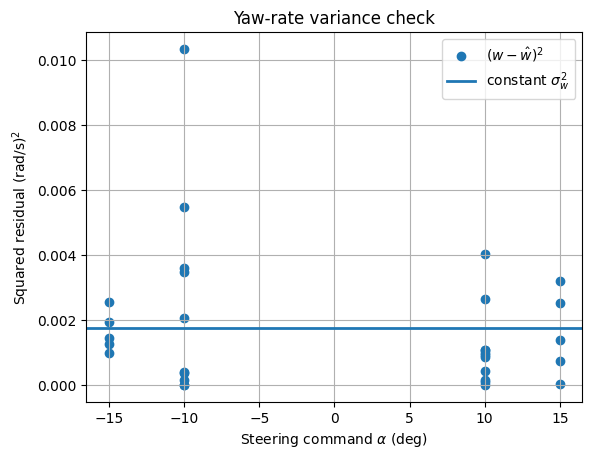

In [20]:
sigma_w2 = np.mean(res**2)
print("sigma_w^2 =", sigma_w2, "(rad/s)^2")

plt.figure()
plt.scatter(alpha_deg, res**2, label="$(w-\\hat{w})^2$")
plt.axhline(sigma_w2, linewidth=2, label="constant $\\sigma_w^2$")
plt.xlabel("Steering command $\\alpha$ (deg)")
plt.ylabel("Squared residual (rad/s)$^2$")
plt.title("Yaw-rate variance check")
plt.grid(True)
plt.legend()
plt.show()


In [37]:
# External Libraries
import math
import random

# -----------------------------
# Motion Model calibration constants (from your notebook)
# -----------------------------

# Distance mapping: s = k_se * e_fwd, where e_fwd = -(delta encoder counts)
K_SE = 0.00028851708972299  # meters per count

# Distance variance mapping: sigma_s^2 = k_ss * e_fwd
K_SS = 7.342396346880917e-08  # (m^2) per count

# Yaw-rate mapping coefficients (no symmetry constraint)
# w = b0 + b1*v + b2*a + b3*v*a + b4*a^2 + b5*v^2 + b6*v*a^2
# where a = steering angle in radians; v = speed command (80/100, etc.)
B0 = -3.97536968e-05
B1 = -1.76673990e-03
B2 = -5.16057305e-01
B3 =  2.47746185e-02
B4 = -4.29707073e-05
B5 =  1.63932739e-05
B6 = -4.22979202e-03

# Yaw-rate variance (constant)
SIGMA_W2_CONST = 0.0008853605431128998  # (rad/s)^2

# Numerics
DTH_EPS = 1e-6


# -----------------------------
# Helpers
# -----------------------------
def wrap_to_pi(angle_rad):
    return (angle_rad + math.pi) % (2.0 * math.pi) - math.pi


# -----------------------------
# Section 3: encoder -> distance + variance
# -----------------------------
def variance_distance_travelled_s(e_fwd_counts):
    """
    sigma_s^2 = k_ss * e_fwd
    Always nonnegative for e_fwd >= 0.
    """
    e = float(e_fwd_counts)
    if e < 0.0:
        # If someone accidentally passes raw counts, protect ourselves
        e = abs(e)
    return K_SS * e


def distance_travelled_s(delta_encoder_counts):
    """
    s = k_se * e_fwd, e_fwd = -delta_e (because forward raw counts are negative)
    """
    delta_e = float(delta_encoder_counts)
    e_fwd = -delta_e
    return K_SE * e_fwd


# -----------------------------
# Section 5: steering+speed -> yaw rate + variance
# -----------------------------
def variance_rotational_velocity_w(v_cmd, steering_angle_command):
    """
    Baseline: constant yaw-rate variance.
    """
    return SIGMA_W2_CONST


def rotational_velocity_w(v_cmd, steering_angle_command, alpha_is_degrees=True):
    """
    w = f_w(v, alpha) with fitted coefficients (no symmetry constraint).
    v_cmd: speed command (e.g., 80, 100)
    steering_angle_command: alpha (deg by default)
    Returns w in rad/s.
    """
    v = float(v_cmd)
    a = float(steering_angle_command)
    if alpha_is_degrees:
        a = math.radians(a)  # radians

    w = (
        B0
        + B1 * v
        + B2 * a
        + B3 * (v * a)
        + B4 * (a ** 2)
        + B5 * (v ** 2)
        + B6 * (v * (a ** 2))
    )
    return w


# -----------------------------
# Motion Model class
# -----------------------------
class MyMotionModel:
    """
    State x = [x_G, y_G, theta_G] (m, m, rad)

    step_update() integrates:
      - s from encoder delta using f_se
      - w from f_w using (v_cmd_default, steering_angle_command)

    IMPORTANT:
      Your fitted w-model uses v as the SPEED COMMAND (80/100),
      so you should pass v_cmd_default per trial (or per dataset).
    """

    def __init__(self, initial_state, last_encoder_count, v_cmd_default=None, add_noise=True, alpha_is_degrees=True):
        self.state = [float(initial_state[0]), float(initial_state[1]), float(initial_state[2])]
        self.last_encoder_count = float(last_encoder_count)
        self.v_cmd_default = v_cmd_default  # set this! e.g. 80 or 100 for that trial
        self.add_noise = add_noise
        self.alpha_is_degrees = alpha_is_degrees

    def step_update(self, encoder_counts, steering_angle_command, delta_t):
        """
        Implements x_t = f(x_{t-1}, u_t), where u_t is derived from:
          s = distance_travelled_s(delta_encoder)
          w = rotational_velocity_w(v_cmd_default, steering_angle_command)
        """
        # --- 1) distance increment from encoders ---
        enc = float(encoder_counts)
        delta_e = enc - self.last_encoder_count
        self.last_encoder_count = enc

        s = distance_travelled_s(delta_e)  # meters

        # --- 2) yaw rate from steering & speed command ---
        if self.v_cmd_default is None:
            raise ValueError(
                "MyMotionModel requires v_cmd_default (e.g., 80 or 100), "
                "because your fitted yaw-rate model uses speed COMMAND units."
            )

        w = rotational_velocity_w(self.v_cmd_default, steering_angle_command, alpha_is_degrees=self.alpha_is_degrees)

        # --- 3) optionally inject noise using calibrated variances ---
        if self.add_noise:
            e_fwd = -delta_e  # forward counts
            var_s = variance_distance_travelled_s(e_fwd)
            s_noisy = s + random.gauss(0.0, math.sqrt(var_s)) if var_s > 0.0 else s

            var_w = variance_rotational_velocity_w(self.v_cmd_default, steering_angle_command)
            w_noisy = w + random.gauss(0.0, math.sqrt(var_w)) if var_w > 0.0 else w
        else:
            s_noisy = s
            w_noisy = w

        # --- 4) exact constant-curvature integration ---
        x, y, th = self.state
        dt = float(delta_t)
        dth = w_noisy * dt

        if abs(dth) < DTH_EPS:
            # straight approximation
            x_new = x + s_noisy * math.cos(th)
            y_new = y + s_noisy * math.sin(th)
            th_new = th + dth
        else:
            R = s_noisy / dth
            th2 = th + dth
            x_new = x + R * (math.sin(th2) - math.sin(th))
            y_new = y - R * (math.cos(th2) - math.cos(th))
            th_new = th2

        self.state = [x_new, y_new, wrap_to_pi(th_new)]
        return self.state

    def traj_propagation(self, time_list, encoder_count_list, steering_angle_list):
        x_list = [self.state[0]]
        y_list = [self.state[1]]
        theta_list = [self.state[2]]

        self.last_encoder_count = float(encoder_count_list[0])

        for i in range(1, len(encoder_count_list)):
            delta_t = float(time_list[i]) - float(time_list[i - 1])
            new_state = self.step_update(encoder_count_list[i], steering_angle_list[i], delta_t)
            x_list.append(new_state[0])
            y_list.append(new_state[1])
            theta_list.append(new_state[2])

        return x_list, y_list, theta_list

    def generate_simulated_traj(self, duration):
        # Optional demo, not required for the lab
        delta_t = 0.1
        t_list, x_list, y_list, theta_list = [], [], [], []
        t = 0.0
        encoder_counts = self.last_encoder_count
        steer = 0.0

        while t < duration:
            t_list.append(t)
            x_list.append(self.state[0])
            y_list.append(self.state[1])
            theta_list.append(self.state[2])

            # Fake encoder increments for illustration only
            encoder_counts += -50.0  # negative forward counts
            self.step_update(encoder_counts, steer, delta_t)
            t += delta_t

        return t_list, x_list, y_list, theta_list


In [38]:

def generate_random_trial(
    duration_s=12.0,
    dt=0.05,
    v_cmd=100,               # use 80 or 100 (matches your yaw-rate fit)
    steer_max=20.0,          # setpoint limits
    steer_rw_sigma=1.0,      # random-walk step (setpoint units) per timestep
    steer_slew_per_s=20.0,  # max steering change rate (setpoint units / second)
    counts_rate_map={80: 1500, 100: 2000},  # counts/second (tunable)
    counts_noise_frac=0.08,  # relative noise on counts increment
    seed=None
):
    """
    Returns:
      time_list (N,)
      encoder_counts_abs (N,)  absolute encoder count
      steering_setpoint (N,)   in [-steer_max, steer_max]
      v_cmd (scalar)
    """
    rng = np.random.default_rng(seed)

    N = int(np.floor(duration_s / dt)) + 1
    time_list = np.linspace(0.0, duration_s, N)

    # --- steering: smooth random walk with slew limit + clamp ---
    steer = np.zeros(N, dtype=float)
    slew_per_step = steer_slew_per_s * dt

    for i in range(1, N):
        # random walk proposal
        propose = steer[i-1] + rng.normal(0.0, steer_rw_sigma)

        # slew limit
        delta = np.clip(propose - steer[i-1], -slew_per_step, slew_per_step)
        steer[i] = steer[i-1] + delta

        # clamp
        steer[i] = np.clip(steer[i], -steer_max, steer_max)

    # --- encoder counts: negative increments for forward motion ---
    rate = counts_rate_map.get(int(v_cmd), 1800)  # counts/sec
    encoder_counts_abs = np.zeros(N, dtype=float)
    enc = 0.0
    encoder_counts_abs[0] = enc

    for i in range(1, N):
        mean_counts = rate * dt

        # noisy positive magnitude then negate (forward is negative delta_e)
        mag = mean_counts * (1.0 + rng.normal(0.0, counts_noise_frac))
        mag = max(0.0, mag)

        delta_e = -mag
        enc = enc + delta_e
        encoder_counts_abs[i] = enc

    return time_list.tolist(), encoder_counts_abs.tolist(), steer.tolist(), v_cmd


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rollout_same_traj_many_times(
    MyMotionModel,
    time_list,
    encoder_count_list,
    steering_angle_list,
    v_cmd_default,
    K=200,
    plot_nominal=True
):
    plt.figure()

    # 1) Nominal (no noise) once
    if plot_nominal:
        mm0 = MyMotionModel(
            initial_state=[0.0, 0.0, 0.0],
            last_encoder_count=encoder_count_list[0],
            v_cmd_default=v_cmd_default,
            add_noise=True,
            alpha_is_degrees=True,
        )
        x0, y0, th0 = mm0.traj_propagation(time_list, encoder_count_list, steering_angle_list)
        plt.plot(x0, y0, linewidth=3, label="nominal (no noise)")

    # 2) K noisy rollouts with the SAME inputs
    for k in range(K):
        mm = MyMotionModel(
            initial_state=[0.0, 0.0, 0.0],
            last_encoder_count=encoder_count_list[0],
            v_cmd_default=v_cmd_default,
            add_noise=True,
            alpha_is_degrees=True,
        )
        x, y, th = mm.traj_propagation(time_list, encoder_count_list, steering_angle_list)
        plt.plot(x, y, alpha=0.08, linewidth=1)

    plt.axis("equal")
    plt.grid(True)
    plt.xlabel("x_G (m)")
    plt.ylabel("y_G (m)")
    plt.title(f"Same trajectory inputs, repeated {K} times (Monte Carlo)")
    plt.legend()
    plt.show()


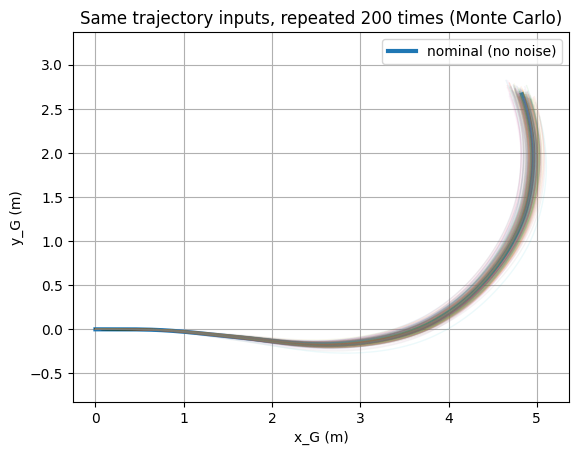

In [41]:
# Generate ONE random control sequence
t_list, enc_list, steer_list, v_cmd = generate_random_trial(duration_s=12.0, dt=0.05, v_cmd=100)

# Run the SAME traj 200 times
rollout_same_traj_many_times(MyMotionModel, t_list, enc_list, steer_list, v_cmd_default=v_cmd, K=200)


In [42]:
import numpy as np
import matplotlib.pyplot as plt

def final_points_same_traj(
    MyMotionModel,
    time_list,
    encoder_count_list,
    steering_angle_list,
    v_cmd_default,
    K=500,
    add_nominal=True,
    plot=True,
):
    finals = np.zeros((K, 3), dtype=float)  # [x, y, theta]

    for k in range(K):
        mm = MyMotionModel(
            initial_state=[0.0, 0.0, 0.0],
            last_encoder_count=encoder_count_list[0],
            v_cmd_default=v_cmd_default,
            add_noise=True,
            alpha_is_degrees=True,
        )
        x_list, y_list, th_list = mm.traj_propagation(time_list, encoder_count_list, steering_angle_list)
        finals[k, :] = [x_list[-1], y_list[-1], th_list[-1]]

    nominal = None
    if add_nominal:
        mm0 = MyMotionModel(
            initial_state=[0.0, 0.0, 0.0],
            last_encoder_count=encoder_count_list[0],
            v_cmd_default=v_cmd_default,
            add_noise=False,
            alpha_is_degrees=True,
        )
        x0, y0, th0 = mm0.traj_propagation(time_list, encoder_count_list, steering_angle_list)
        nominal = np.array([x0[-1], y0[-1], th0[-1]])

    if plot:
        plt.figure()
        plt.scatter(finals[:, 0], finals[:, 1], s=10, alpha=0.25, label=f"Noisy endpoints (K={K})")
        if nominal is not None:
            plt.scatter([nominal[0]], [nominal[1]], s=80, marker="x", label="Nominal endpoint")
        plt.axis("equal")
        plt.grid(True)
        plt.xlabel("x_G (m)")
        plt.ylabel("y_G (m)")
        plt.title("Monte Carlo final endpoints for the same input sequence")
        plt.legend()
        plt.show()

    return finals, nominal


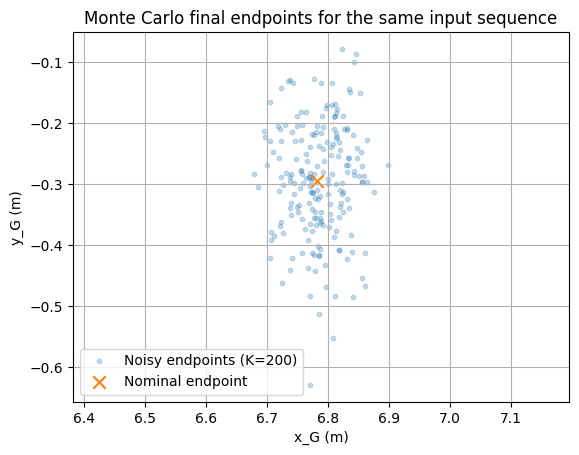

Mean endpoint: [ 6.78561221 -0.29428814]
Endpoint covariance:
 [[0.00188304 0.00012862]
 [0.00012862 0.00852358]]


In [47]:
# Generate ONE control sequence (or use a real trial)
t_list, enc_list, steer_list, v_cmd = generate_random_trial(duration_s=12.0, dt=0.05, v_cmd=100)

# Run same trajectory 500 times, keep only endpoints
finals, nominal = final_points_same_traj(
    MyMotionModel,
    t_list, enc_list, steer_list,
    v_cmd_default=v_cmd,
    K=200,
    plot=True
)

print("Mean endpoint:", finals[:, :2].mean(axis=0))
print("Endpoint covariance:\n", np.cov(finals[:, 0], finals[:, 1]))
